reading, storing, and plotting data

In [387]:
import matplotlib.pyplot as plt
import random as rnd
from math import dist

# ----- read and clean datapoints -----
def generate_data_from_file():
    """
    Read file datapoints.txt -> clean and store data in dictionary -> return data dictionary
    """
    file_path = "assets/datapoints.txt"

    with open(file_path, "r") as file_r:
        datapoints = [row.strip("\n").split(", ") for row in file_r] # split each row into a list of 3 elements, remove newlines, and store list as element in datapoints list
        datapoints.remove(datapoints[0]) # remove column header
        datapoints = [[float(element) for element in point] for point in datapoints]

    data = { # dictionary containing all pokemon, and their width/height measurements
        "pikachu" : {
        "width"   : [i[0] for i in datapoints if i[2] == 1],
        "height"  : [i[1] for i in datapoints if i[2] == 1]
        },
        "pichu"   : {
        "width"   : [i[0] for i in datapoints if i[2] == 0],
        "height"  : [i[1] for i in datapoints if i[2] == 0]
        }
    }

    return data

# ----- read and clean testpoints -----
def generate_test_data_from_file():
    """
    Read file testpoints.txt -> clean and store data in dictionary -> return data dictionary
    """
    file_path = "assets/testpoints.txt"

    with open(file_path, "r") as file_r:
        testpoints = [row[4:-2].split(", ") for row in file_r]
        testpoints.remove(testpoints[0])
        testpoints = [[float(element) for element in point] for point in testpoints]

    test_data = { # dictionary containing all undefined points, and their width/height measurements
        "undefined" : {
        "width"   : [i[0] for i in testpoints],
        "height"  : [i[1] for i in testpoints]
        }
    }

    return test_data
        
# ----- plot data from data (and test data) -----
def plot_data(data, test_data = 0, incorrect_predictions = 0):
    """
    Takes data dictionary (optional test_data dictionary) -> Create scatterplot of data (test_data)
    """

    # TODO: add option to plot incorrect results from accuracy function in a different color to show which points were incorrectly categorized

    # ----- plot pikachu and pichu datapoints -----
    plt.scatter(data["pikachu"]["width"],  data["pikachu"]["height"], color = "orange", label = "Pikachus")
    plt.scatter(data["pichu"]["width"],    data["pichu"]["height"],   color = "red",  label = "Pichus")

    if test_data != 0: # if test data was added as input parameter:
        if "undefined" in test_data: # plot undefined unknown points
            plt.scatter(test_data["undefined"]["width"],  test_data["undefined"]["height"], color = "blue", label = "Undefined")
        if "pikachu" in test_data: # plot undefined pikachus
            plt.scatter(test_data["pikachu"]["width"],  test_data["pikachu"]["height"], color = "black", label = "Undefined (Pikachu)")
        if "pichu" in test_data: # plot undefined pichus
            plt.scatter(test_data["pichu"]["width"],  test_data["pichu"]["height"], color = "blue", label = "Undefined (Pichu)")

    if incorrect_predictions != 0:
        if "pikachu" in incorrect_predictions:
            plt.scatter(incorrect_predictions["pikachu"]["width"], incorrect_predictions["pikachu"]["height"], color = "green", label = "Incorrect (actual Pikachu)")
        if "pichu" in incorrect_predictions:
            plt.scatter(incorrect_predictions["pichu"]["width"], incorrect_predictions["pichu"]["height"], color = "purple", label = "Incorrect (actual Pichu)")

    plt.title("Scatterplot of width / height measurements of pokemon")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.legend();

# ----- format and error handle user input -----
def clean_user_input():
    """
    Prompt user for input datapoint -> Return input coordinates (float, x, y) and amount_votes (int, default 1)

    Clean and format input for use in categorize_point()
    """
    while True:
        user_input = input("Enter a manual point to categorize, formatted like 'width, height' (x, y):\n(Optionally enter a third number for amount of votes, default: 1)")
        try:
            user_input = user_input.split(",")
            user_input = [float(i.strip()) for i in user_input] # remove empty space
            valid_input = True

            for i in user_input:
                if i <= 0:
                    print(f"'{i}' is not a valid input, make sure to enter positive numbers only")
                    valid_input = False

            if valid_input == True:
                width = user_input[0]
                height = user_input[1]
                if len(user_input) >= 3: # if user entered a third number
                    amount_votes = int(user_input[2]) # set majority vote
                else:
                    amount_votes = 1 # majority vote defaults to 1
                
                return width, height, amount_votes

            
        except ValueError as err:
            print(f"{err} is not a valid point, make sure to enter 2-3 positive numbers")

# ----- categorize specific point compared to data, based off majority vote on euclidean distance -----
def categorize_point(point, data, amount_votes = 1):
    """
    Take point (x, y) to categorize, data dictionary (and optional amount_votes int) -> Return category(str), certainty(float)
    
    Calculate distance from input point to datapoints,
    Categorize point based on proximity to datapoints,
    Calculate certainty of categorization
    """
    distance_list = []

    for i in range(len(data["pikachu"]["width"])): # calculate distance between all pikachu / pichu points and (x, y), and store them in distance
        distance_list.append([dist((data["pikachu"]["width"][i], data["pikachu"]["height"][i]), (point[0], point[1])), "pikachu"])
        distance_list.append([dist((data["pichu"]["width"][i], data["pichu"]["height"][i]), (point[0], point[1])), "pichu"])

    distance_list.sort() # sort distance, this sorts on the first index of lists in distance list, and keeps the pokemon tag

    del distance_list[amount_votes::] # remove indices of distance outside the votes specified to be taken into consideration

    category = ""
    certainty = 0

    distance_pikachu = [distance[0] for distance in distance_list if distance[1] == "pikachu"]
    distance_pichu = [distance[0] for distance in distance_list if distance[1] == "pichu"]

    # ----- return most category represented in distance measurements -----
    if len(distance_pikachu) > len(distance_pichu):
        category = "pikachu"
        certainty = len(distance_pikachu) / (len(distance_pikachu) + len(distance_pichu))
        return category, certainty
    elif len(distance_pichu) > len(distance_pikachu):
        category = "pichu"
        certainty = len(distance_pichu) / (len(distance_pikachu) + len(distance_pichu))
        return category, certainty

    # ----- if distance measurements of different categories is equally represented -----
    if len(distance_pikachu) == len(distance_pichu):

        # ----- calculate weighted distance (smaller is better) -----
        weighted_distance_pikachu = sum(distance_pikachu) / len(distance_pikachu)
        weighted_distance_pichu = sum(distance_pichu) / len(distance_pichu)

        # ----- return smallest weighted distance to point -----
        if weighted_distance_pikachu < weighted_distance_pichu: 
            category = "pikachu"
            certainty = weighted_distance_pichu / (weighted_distance_pikachu + weighted_distance_pichu)
            return category, certainty
        else:
            category = "pichu"
            certainty = weighted_distance_pikachu / (weighted_distance_pichu + weighted_distance_pikachu)
            return category, certainty

# ----- randomly split data into test and training data -----
def generate_test_training_data(data):
    """
    Takes data dictionary -> Return test_data and training_data dictionaries

    Split data dictionary into two at random,
    Test_dictionary = 50 datapoints (25 pikachu / pichu),
    Training_dictionary = 100 datapoints (50 pikachu / pichu)
    """

    test_data       = {"pikachu" : {"width" : [], "height" : []}, "pichu" : {"width" : [], "height" : []}}
    training_data   = {"pikachu" : {"width" : [], "height" : []}, "pichu" : {"width" : [], "height" : []}}

    # ----- randomly splitting pikachus into test and training groups -----
    random_point_pikachu = rnd.sample(range(0, 75), 25)
    test_data["pikachu"]["width"] = [data["pikachu"]["width"][i] for i in random_point_pikachu]
    test_data["pikachu"]["height"] = [data["pikachu"]["height"][i] for i in random_point_pikachu]

    training_data["pikachu"]["width"] = [data["pikachu"]["width"][i] for i in range(75) if i not in random_point_pikachu]
    training_data["pikachu"]["height"] = [data["pikachu"]["height"][i] for i in range(75) if i not in random_point_pikachu]

    # ----- randomly splitting pichus into test and training groups -----
    random_point_pichu = rnd.sample(range(0, 75), 25) # second random here for pichu randoms
    test_data["pichu"]["width"] = [data["pichu"]["width"][i] for i in random_point_pichu]
    test_data["pichu"]["height"] = [data["pichu"]["height"][i] for i in random_point_pichu]

    training_data["pichu"]["width"] = [data["pichu"]["width"][i] for i in range(75) if i not in random_point_pichu]
    training_data["pichu"]["height"] = [data["pichu"]["height"][i] for i in range(75) if i not in random_point_pichu]

    # NOTE: use to check that no same point is picked twice:
    # print(f"Random Point: {random_point_pikachu}")
    # print(f"Not random: {[i for i in range(75) if i not in random_point_pikachu]}")

    return test_data, training_data # to use in functions

# ----- calculate accuracy of calculations by comparing generated test and training data -----
def calculate_accuracy(test_data, data, amount_votes = 1):
    """
    Takes test_data and data dictionary (optional amount_votes) -> Return accuracy (float)

    Calls categorize_point() for each point in test_data compared to data,
    Calculates combined accuracy of categorization of all points
    """
    incorrect_predictions = {"pikachu" : {"width" : [], "height" : []}, "pichu" : {"width" : [], "height" : []}}

    TP, TN, FP, FN = 0, 0, 0, 0

    for i in range(len(test_data["pikachu"]["width"])):

        result = categorize_point([test_data["pikachu"]["width"][i], test_data["pikachu"]["height"][i]], data,  amount_votes)

        if result[0] == "pikachu":
            TP += 1
        else:
            FP += 1
            incorrect_predictions["pikachu"]["width"].append(test_data["pikachu"]["width"][i])
            incorrect_predictions["pikachu"]["height"].append(test_data["pikachu"]["height"][i])
        
        result = categorize_point([test_data["pichu"]["width"][i], test_data["pichu"]["height"][i]], data,  amount_votes)

        if result[0] == "pichu":
            TN += 1
        else:
            FN += 1
            incorrect_predictions["pichu"]["width"].append(test_data["pichu"]["width"][i])
            incorrect_predictions["pichu"]["height"].append(test_data["pichu"]["height"][i])

    accuracy = (TP + TN) / (TP + TN + FP + FN)

    return accuracy, TP, TN, FP, FN, incorrect_predictions


## Read, clean, and store data from files

In [388]:
data = generate_data_from_file()
test_data = generate_test_data_from_file()

## Plot datapoints, and test points (optional)

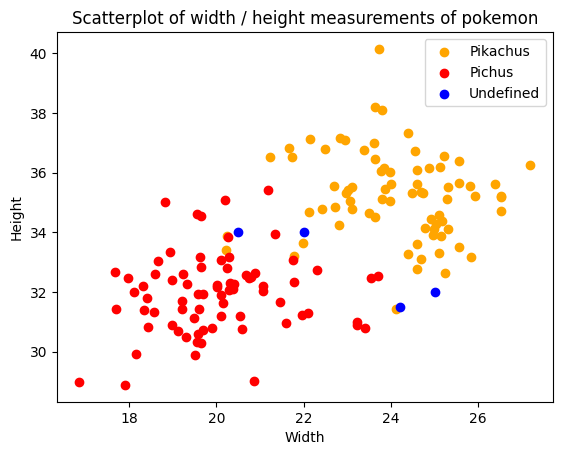

In [389]:
data = generate_data_from_file()
test_data = generate_test_data_from_file()

plot_data(data, test_data)

## Calculate distance and categorize test point

Majority vote of 1:

In [390]:
data = generate_data_from_file()
test_data = generate_test_data_from_file()
amount_votes = 1 # set this to any number of majority votes

for point in range(len(test_data["undefined"]["width"])):
    result = categorize_point([test_data["undefined"]["width"][point], test_data["undefined"]["height"][point]], data, amount_votes)
    print(f'Point {test_data["undefined"]["width"][point], test_data["undefined"]["height"][point]} calculated as "{result[0].capitalize()}"')
    print(f"({result[1] * 100:.1f}% certainty based on a majority vote of {amount_votes})\n")

Point (25.0, 32.0) calculated as "Pikachu"
(100.0% certainty based on a majority vote of 1)

Point (24.2, 31.5) calculated as "Pikachu"
(100.0% certainty based on a majority vote of 1)

Point (22.0, 34.0) calculated as "Pikachu"
(100.0% certainty based on a majority vote of 1)

Point (20.5, 34.0) calculated as "Pichu"
(100.0% certainty based on a majority vote of 1)



Majority vote of 10:

In [391]:
data = generate_data_from_file()
test_data = generate_test_data_from_file()
amount_votes = 10 # set this to any number of majority votes

for point in range(len(test_data["undefined"]["width"])):
    result = categorize_point([test_data["undefined"]["width"][point], test_data["undefined"]["height"][point]], data, amount_votes)
    print(f'Point {test_data["undefined"]["width"][point], test_data["undefined"]["height"][point]} calculated as "{result[0].capitalize()}"')
    print(f"({result[1] * 100:.1f}% certainty based on a majority vote of {amount_votes})\n")

Point (25.0, 32.0) calculated as "Pikachu"
(80.0% certainty based on a majority vote of 10)

Point (24.2, 31.5) calculated as "Pichu"
(53.4% certainty based on a majority vote of 10)

Point (22.0, 34.0) calculated as "Pikachu"
(70.0% certainty based on a majority vote of 10)

Point (20.5, 34.0) calculated as "Pichu"
(80.0% certainty based on a majority vote of 10)



## Manually input point to categorize

In [392]:
data = generate_data_from_file()

user_input = clean_user_input()
result = categorize_point([user_input[0], user_input[1]], data, user_input[2])
print(f"Width, height {user_input[0], user_input[1]} calculated as '{result[0]}' with {result[1] * 100:.1f}% certainty (based on a majority vote of {user_input[2]})")

Width, height (32.5, 23.4) calculated as 'pikachu' with 70.0% certainty (based on a majority vote of 10)


## Randomly split original data into new test and training data  
Calculate accuracy of predicted categories  
Plot graph of test and training points

Accuracy of categorization: 96.0%
Correct predictions: Pikachu 24/25, Pichu 24/25 (based on a majority vote of 10


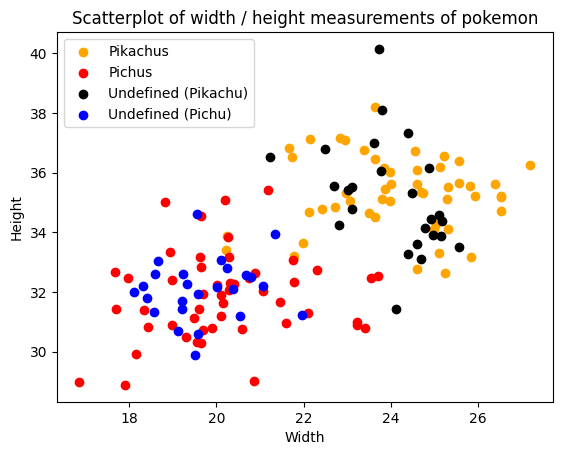

In [396]:
data = generate_data_from_file() # read in datapoints file and store as data
test_data, training_data = generate_test_training_data(data) # split datapoints in data randomly into 2 groups; test and training data
amount_votes = 10

plot_data(training_data, test_data)

accuracy, TP, TN, FP, FN, incorrect_predictions = calculate_accuracy(test_data, training_data, amount_votes)

print(f"Accuracy of categorization: {accuracy * 100}%")
print(f"Correct predictions: Pikachu {TP}/{TP + FP}, Pichu {TN}/{TN + FN} (based on a majority vote of {amount_votes}")

Plot graph of incorrectly predicted test points next to training points

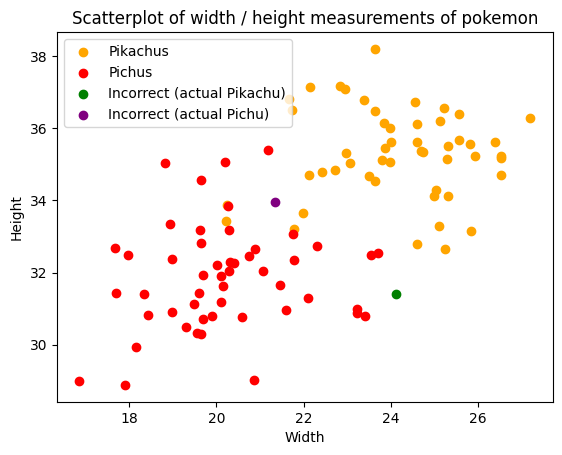

In [397]:
plot_data(training_data, incorrect_predictions = incorrect_predictions)

## Plot accuracy of multiple sets of test and training data

Randomly split data into test and training data  
Calculate accuracy of test data categorization compared to training data  
Graph calculated accuracy  
Calculate average accuracy of multiple sets of simulations  

Prediction accuracy of simulation 1: 96.0% - Correct predictions: Pikachu 23/25, Pichu 25/25
Prediction accuracy of simulation 2: 96.0% - Correct predictions: Pikachu 23/25, Pichu 25/25
Prediction accuracy of simulation 3: 96.0% - Correct predictions: Pikachu 23/25, Pichu 25/25
Prediction accuracy of simulation 4: 98.0% - Correct predictions: Pikachu 24/25, Pichu 25/25
Prediction accuracy of simulation 5: 98.0% - Correct predictions: Pikachu 25/25, Pichu 24/25
Prediction accuracy of simulation 6: 94.0% - Correct predictions: Pikachu 23/25, Pichu 24/25
Prediction accuracy of simulation 7: 96.0% - Correct predictions: Pikachu 23/25, Pichu 25/25
Prediction accuracy of simulation 8: 96.0% - Correct predictions: Pikachu 23/25, Pichu 25/25
Prediction accuracy of simulation 9: 88.0% - Correct predictions: Pikachu 20/25, Pichu 24/25
Prediction accuracy of simulation 10: 90.0% - Correct predictions: Pikachu 21/25, Pichu 24/25

Average accuracy of all 10 simulations: 94.8%


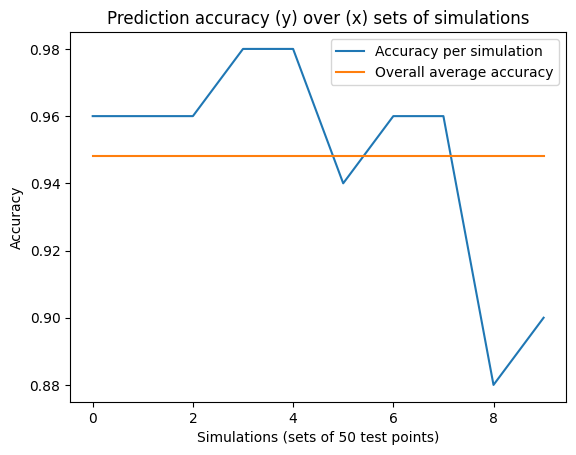

In [400]:
accuracy_list = []
amount_simulations = 10
amount_votes = 10

for i in range(amount_simulations):
    data = generate_data_from_file() # read in datapoints file and store as data
    test_data, training_data = generate_test_training_data(data) # split datapoints in data randomly into 2 groups; test and training data

    accuracy, TP, TN, FP, FN, incorrect_predictions = calculate_accuracy(test_data, training_data, amount_votes) # categorize points of test data compared to training data, and calculate accuracy of predictions
    accuracy_list.append(accuracy)
    
    print(f"Prediction accuracy of simulation {i + 1}: {accuracy * 100}% - Correct predictions: Pikachu {TP}/{TP + FP}, Pichu {TN}/{TN + FN}")

average_accuracy = sum(accuracy_list) / len(accuracy_list)

plt.plot(accuracy_list, label = "Accuracy per simulation")
plt.plot(range(amount_simulations), [average_accuracy for i in range(amount_simulations)], label = "Overall average accuracy")
plt.title("Prediction accuracy (y) over (x) sets of simulations")
plt.xlabel("Simulations (sets of 50 test points)")
plt.ylabel("Accuracy")
plt.legend();

print(f"\nAverage accuracy of all {amount_simulations} simulations: {average_accuracy * 100:.1f}%")